In [1]:
from csv import QUOTE_NONNUMERIC

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = 16, 9

In [6]:
collections = [
    "agora",
    "bigg",
    "carveme",
    "ebrahim",
    "kbase",
    "metagem_gut",
    "metagem_tara",
    "optflux",
    "path"
]

In [7]:
files = [
    "../data/agora.csv.gz",
    "../data/bigg.csv.gz",
    "../data/carveme.csv.gz",
    "../data/ebrahim.csv.gz",
    "../data/kbase.csv.gz",
    "../data/metagem_gut.csv.gz",
    "../data/metagem_tara.csv.gz",
    "../data/optflux.csv.gz",
    "../data/path.csv.gz"
]

In [8]:
colors = [
  "#A6A9AA",
  "#000000",
  "#A3D2E2",
  "#3E7CBC",
  "#EDA85F",
  "#F29FA9",
  "#289261",
  "#CD2028",
  "#737878"
]

## Extract

In [9]:
bucket = []
for filename, collection in zip(files, collections):
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [10]:
df.shape

(2170588, 11)

In [11]:
df.head()

,test,title,section,metric,numeric,model,time,score,weight,status,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,5762.29,Eggerthella_sp_1_3_56FAA,0.016577,NaN,NaN,passed,agora
1,test_biomass_consistency,Biomass Consistency,test_biomass,NaN,NaN,Eggerthella_sp_1_3_56FAA,0.000461,NaN,NaN,failed,agora
2,test_biomass_consistency,Biomass Consistency,test_biomass,NaN,NaN,Eggerthella_sp_1_3_56FAA,0.000430,NaN,NaN,failed,agora
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,59.9503,Eggerthella_sp_1_3_56FAA,0.002195,NaN,NaN,passed,agora
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,59.9503,Eggerthella_sp_1_3_56FAA,0.133996,NaN,NaN,passed,agora


## Transform

### Filter _E. coli_ Strain Models

In [12]:
taxonomy = pd.read_csv("../data/bigg_taxonomy.csv.gz")

In [13]:
taxonomy[taxonomy["strain"].isnull()] = ""

In [14]:
strains = taxonomy.loc[taxonomy["strain"].str.startswith("Escherichia coli"), "model"]

Exclude desired models.

In [15]:
strains = strains[~strains.isin(["iML1515", "iJO1366", "iAF1260", "iJR904"])]

In [16]:
df = df.loc[
    ~((df["collection"] == "bigg") & df["model"].isin(strains)), :
]

### Restrict to Scored Test Cases

In [17]:
scored_df = df[df["score"].notnull()].copy()

In [18]:
scored_df.shape

(1203059, 11)

### Pivot Table

Each model from each collection is one observation (row) and each test case constitutes one variable or category (column) measuring model performance.

In [19]:
scored_df.set_index(["collection", "model", "test"], inplace=True)

In [20]:
scored_df.describe()

,metric,time,score,weight
count,1.203059e+06,1.203059e+06,1.203059e+06,1.203059e+06
mean,8.721719e-01,1.980388e-01,1.278281e-01,1.024704e+00
std,3.215693e-01,2.212804e+00,3.215693e-01,2.209008e-01
min,0.000000e+00,1.537800e-04,0.000000e+00,1.000000e+00
25%,1.000000e+00,7.157326e-04,0.000000e+00,1.000000e+00
50%,1.000000e+00,1.019955e-03,0.000000e+00,1.000000e+00
75%,1.000000e+00,1.610994e-03,0.000000e+00,1.000000e+00
max,1.000000e+00,3.675861e+02,1.000000e+00,3.000000e+00


Check for duplicates which will prevent unstacking.

In [21]:
scored_df[scored_df.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric,time,score,weight,status
collection,model,test,,,,,,,,


In [22]:
observations = scored_df.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                      \
test                                             test_exchange_specific_sbo_presence   
collection model                                                                       
agora      Abiotrophia_defectiva_ATCC_49176                                      1.0   
           Achromobacter_xylosoxidans_A8                                         1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                 1.0   
           Acidaminococcus_fermentans_DSM_20731                                  1.0   
           Acidaminococcus_intestini_RyC_MR95                                    1.0   

                                                                         \
test                                             test_find_disconnected   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                         0.0   
           Achromobacter_xylosoxidans_A8                            0.0   
           Achromobacter_xylosoxidans_NBRC_15126                    0.0   
           Acidaminococcus_fermentans_DSM_20731                     0.0   
           Acidaminococcus_intestini_RyC_MR95                       0.0   

                                                                                                       \
test                                             test_find_reactions_unbounded_flux_default_condition   
collection model                                                                                        
agora      Abiotrophia_defectiva_ATCC_49176                                                0.185259     
           Achromobacter_xylosoxidans_A8                                                   0.335968     
           Achromobacter_xylosoxidans_NBRC_15126                                           0.324324     
           Acidaminococcus_fermentans_DSM_20731                                            0.253521     
           Acidaminococcus_intestini_RyC_MR95                                              0.184783     

                                                                                             \
test                                             test_gene_product_annotation_overview-asap   
collection model                                                                              
agora      Abiotrophia_defectiva_ATCC_49176                                             1.0   
           Achromobacter_xylosoxidans_A8                                                1.0   
           Achromobacter_xylosoxidans_NBRC_15126                     

### Handle Missing Values

In [23]:
observations.isna().sum(axis=0).sort_values(ascending=False)

        test                                                  
metric  test_gene_product_annotation_overview-ncbigi              59
        test_gene_product_annotation_overview-asap                59
        test_gene_product_annotation_overview-ccds                59
        test_gene_product_annotation_overview-ecogene             59
        test_gene_product_annotation_overview-hprd                59
        test_gene_product_annotation_overview-kegg.genes          59
        test_gene_product_annotation_overview-ncbigene            59
        test_gene_product_annotation_overview-ncbiprotein         59
        test_gene_product_annotation_overview-refseq              59
        test_gene_product_annotation_overview-uniprot             59
        test_metabolite_annotation_overview-inchi                  1
        test_metabolite_annotation_overview-bigg.metabolite        1
        test_metabolite_annotation_overview-seed.compound          1
        test_metabolite_annotation_overv

We set the missing values equivalent to being completely wrong, i.e., score = 0.

In [24]:
observations[observations.isna()] = 0.0

## Dimension Reduction

### PCA

In [25]:
pca = PCA(whiten=True).fit_transform(observations)

In [26]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_pca.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

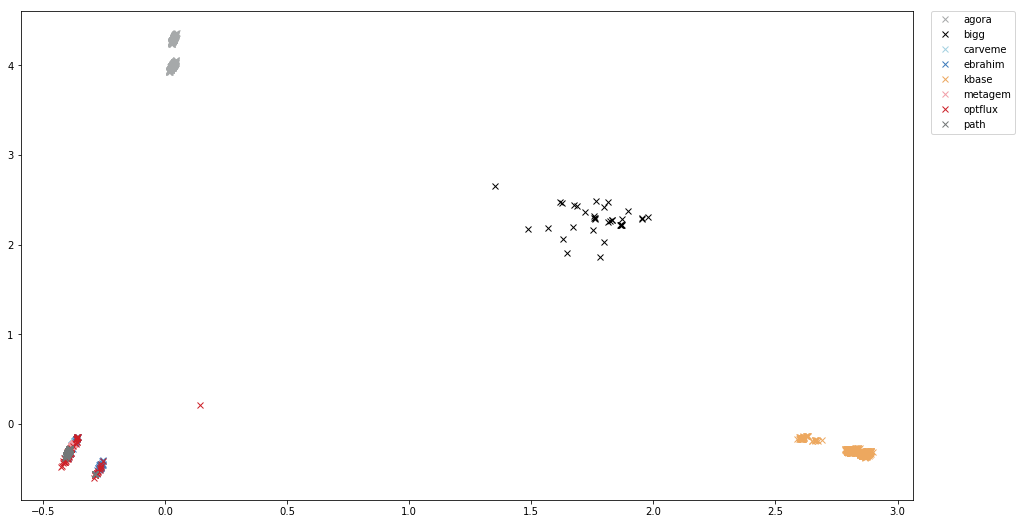

In [27]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [28]:
tsne = TSNE(n_components=2).fit_transform(observations)

In [29]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_tsne.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

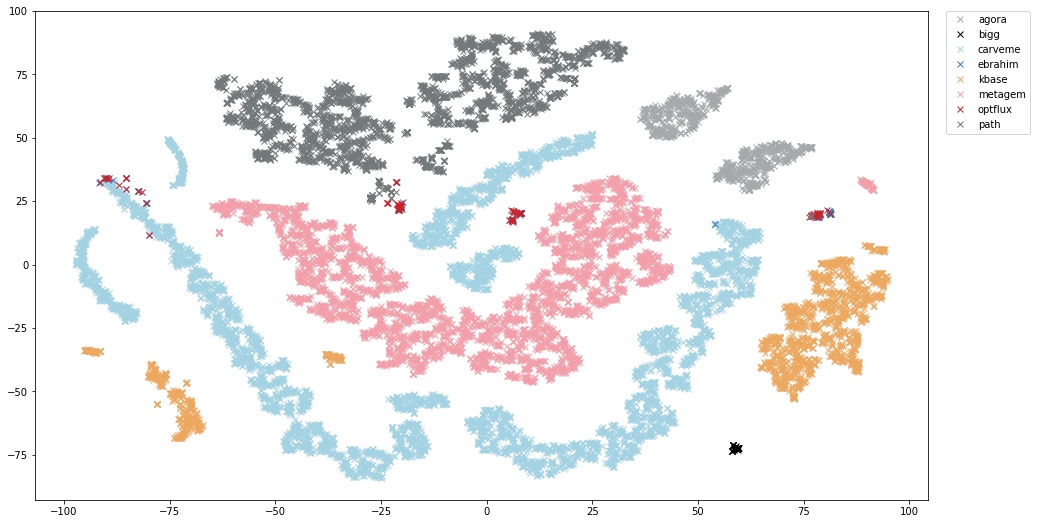

In [30]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [31]:
umap = UMAP(n_components=2).fit_transform(observations)

In [32]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_umap.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

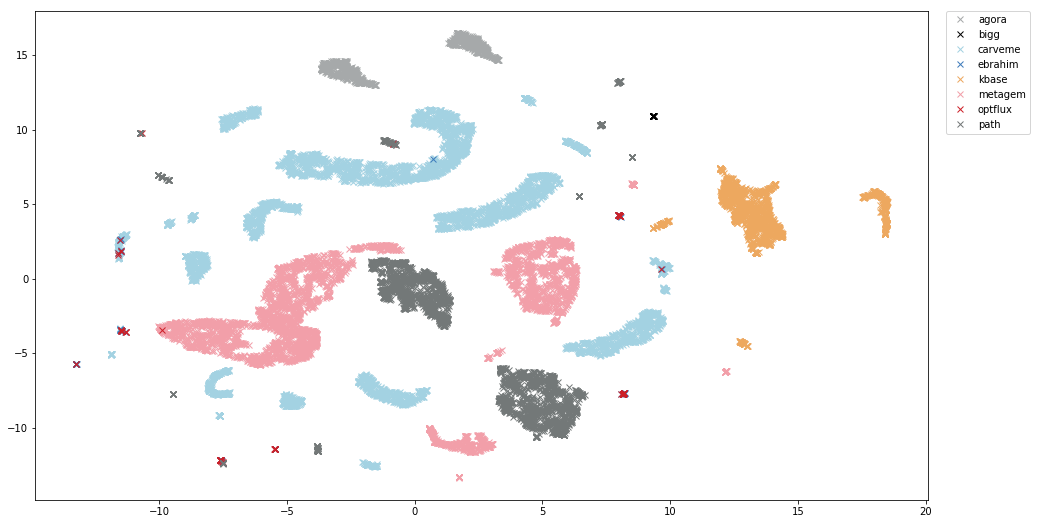

In [33]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()